# Code From Part 1

In [ ]:
from tqdm import tqdm

In [ ]:
from dataclasses import dataclass

@dataclass
class Point:
    '''keeps track of the data for each point p in the csv file '''
    
    date: str # the date this point was recorded
    id: str # the unique id of the car
    x: float # the x coordinate
    y: float # the y coordinate

In [ ]:
import csv

def readPoints(csvFilePath):
    '''a function to convert a csv file of points into a list of Point classes'''

    # read raw data from csv file
    with open(csvFilePath, "r") as f:
        data = list(csv.reader(f, delimiter=","))[1:]

    # iterate through each row and convert the data to a Point class
    points = []
    for p in data:
        # add the Point class onto the list of points
        points.append(Point('', p[0], float(p[1]), float(p[2])))

    # strip the x and y values from points
    xPoints = [p.x for p in points]
    yPoints = [p.y for p in points]

    # compute the boundaries for the points, to be used later in the preprocessing step
    minX, maxX = min(xPoints), max(xPoints)
    minY, maxY = min(yPoints), max(yPoints)

    return points, xPoints, yPoints, minX, maxX, minY, maxY


# initialize the 'points' list to be all the points in the csv file containing 10 percent of the data
csvFilePath = '/work/geolife-cars-upd8.csv'
points, xPoints, yPoints, minX, maxX, minY, maxY = readPoints(csvFilePath)

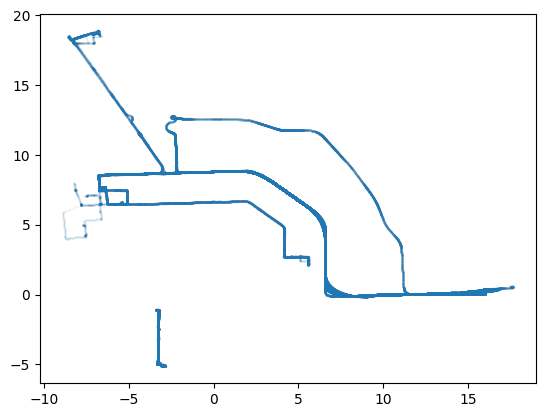

In [ ]:
import matplotlib.pyplot as plt

def visualizePoints(points):
    ''' plot each point to make sure the data is being read properly in 'readPoints' '''

    plt.scatter(xPoints, yPoints, s=0.1, alpha=0.1)
    plt.show()

visualizePoints(points)

## Task 2 - Simplified Trajectory

In [ ]:
def getTrajectory(points, trajectoryId):
    ''' computes a list of points for each trajectory given a trajectory id'''

    # filter through points and add the point if it has the same trajectory id
    T = [p for p in points if p.id == trajectoryId]
    
    return T

In [ ]:
import math

def calculateIntersect(A, slopeA, B, slopeB):
    ''' helper function for task 2 distance function; calcuates the intersect of two lines given slope and a point of each'''
    
    # formula for x value of intersect point
    x_int = (B.y - A.y + slopeA * A.x - slopeB * B.x) / (slopeA - slopeB)
    y_int = slopeA * (x_int - A.x) + A.y

    ret = Point('', '', x_int, y_int)
    return ret

In [ ]:
## Note: q is a Point and e is a tuple of Point Coordinates

def pointEdgeDist(q, e):
    '''  Determines the distance between a point q and edge e'''

    # ensures that edge e is passed with the lower x value first
    if (e[0][0] > e[1][0]): 
        high = e[0]
        low = e[1]
        e = (low, high)

    #set xs and ys and calulcate slope
    x1, y1 = e[0][0], e[0][1]
    x2, y2 = e[1][0], e[1][1]
    slopeOfEdge = (y2-y1)/(x2-x1) if x2-x1 != 0 else 99999 # benji just changed this

    #calculate slope of the perpendicular edge and find intersect between perpendicular line and edge - this is the shortest distance
    slopeOfPerpendicular = -(slopeOfEdge**-1) if slopeOfEdge != 0 else 999999 # benji just changed this
    intersect = calculateIntersect(Point('', '', x1, y1), slopeOfEdge, q, slopeOfPerpendicular)

    #if the perpendicular point is within the x values of the edge, return the minimum of two endpoints and perpendicular
    if (intersect.x >= x1 and intersect.x <= x2): 
        return min(math.dist((q.x, q.y), (e[0][0], e[0][1])), math.dist((q.x, q.y), (e[1][0], e[1][1])),
        math.dist((q.x, q.y), (intersect.x, intersect.y)))
    else: #return the minimum of just the endpoints
        return min(math.dist((q.x, q.y), (e[0][0], e[0][1])), math.dist((q.x, q.y), (e[1][0], e[1][1])))

In [ ]:
def getTrajectory(points, trajectoryId):
    ''' computes a list of points for each trajectory given a trajectory id'''

    # filter through points and add the point if it has the same trajectory id
    T = [p for p in points if p.id == trajectoryId]
    
    return T

In [ ]:
def TS_greedy(T, e):
    ''' compute the simplified trajectory using Greedy Algorithm '''
    s, t = T[0], T[len(T)-1]

    # base case: if sub-trajectory size is 2, then return
    if len(range(1, len(T)-1)) <= 2:
        return T

    # find all distances to edge between endpoints s, t
    dists, maxx, ind = [], 0, -1
    for a in T[1:len(T)-1]:
        dists.append(pointEdgeDist(a, ((s.x, s.y), (t.x, t.y))))

    # find the maximum distance from edge 
    if (len(dists)>0):
        maxx = max(dists)
        ind = 1 + dists.index(maxx)
    
    # base case: if sub-trajectory contains no dist greater than error, return
    if maxx <= e:
        return [s, t]
    
    # recursive step: recurse with point in question added into simplified trajectory
    else:
        # print("m: ", maxx ,"err: ",  e)
        return TS_greedy(T[:ind+1], e) + TS_greedy(T[ind:], e)[1:]

In [ ]:
def dist(p1, p2):
    ''' compute the euclidian distance between two Point objects '''
    
    x1, y1 = p1.x, p1.y
    x2, y2 = p2.x, p2.y
    distance = ((x2 - x1) ** 2 + (y2 - y1) ** 2) ** .5
    return distance

def dist2(p1, p2):
    ''' compute the euclidian distance squared between two Point objects '''
    
    x1, y1 = p1.x, p1.y
    x2, y2 = p2.x, p2.y
    distance = (x2 - x1) ** 2 + (y2 - y1) ** 2
    return distance

In [ ]:
def dtw(P, Q):
    ''' compute the dynamic time warping between trajectory P and Q '''

    def createTables():
        ''' initializes and populates the tables D and E
        D(i,j) represents the minimum total distance between all assignments up to index i in trajectory P and up to index j in trajectory Q
        E(i,j) represents |E| in the computation of D(i,J) '''

        # initiliaze D and E to be n by m matrices
        D = [[0 for _ in range(m)] for _ in range(n)]
        E = [[0 for _ in range(m)] for _ in range(n)]

        # initialize the base cases of the tables
        # D(0,0) is the distance between the first two points of the trajectories
        D[0][0] = dist2(P[0], Q[0])
        
        # E(0,0) is 1 because there are 1 total assignments in D(0,0)
        E[0][0] = 1

        # iterate through each cell of the table and populate the tables D and E according to the transition functions
        for i in range(n):
            for j in range(m):
                # skip over (0,0) for both tables, since this base case was previously computed
                if i == j == 0: continue

                # create a list of values for D(i,j) / E(i,j) where i and j are indices for the cells
                # above, to the left, and to the top corner of the current cell
                prevCells = [
                                (dist2(P[i], Q[j]) + D[i+di][j+dj]) / (E[i+di][j+dj] + 1)
                                if 0 <= i+di and 0 <= j+dj
                                else float('inf')
                                for di, dj in offsets
                            ]

                # find the indices of the previous cell that minimizes D(i,j) / E(i,j)
                minD = min(prevCells)
                argminD = prevCells.index(minD)
                di, dj = offsets[argminD]

                # update D(i,j) to be the minimum of previous cells D plus the euclidian distance between P[i] and Q[j]
                D[i][j] = dist2(P[i], Q[j]) + D[i+di][j+dj]

                # update E(i,j) to be the value of 
                E[i][j] = E[i+di][j+dj] + 1
        
        return D, E
    
    def retraceTables(D, E):
        ''' retraces the distances between each pair of assigned points in the optimal solution '''

        # initialize a list of distances between assigned pair
        edgeLengths = []

        # start at the bottom right corner of the tables
        i, j = n-1, m-1

        # iterate through each assignment pair backwards and stop once we reach the top left corner 
        while i != 0 and j != 0:

            # find the previous cell that we used to compute D(i,j) in the 'populateTables' function
            prevCells = [
                            (D[i+di][j+dj]) / (E[i+di][j+dj])
                            if 0 <= i+di and 0 <= j+dj
                            else float('inf')
                            for di, dj in offsets
                        ]

            # find the offsets of this specific cell
            minD = min(prevCells)
            argminD = prevCells.index(minD)
            di, dj = offsets[argminD]

            # compute the length of the assignment pairs and add it to the result
            edgeLength = dist2(P[i+di], Q[j+dj])
            edgeLengths.append(edgeLength)

            # move to this next cell
            i += di
            j += dj

        # insert the edge length between the last points of P and Q
        edgeLengths.insert(0, dist2(P[-1], Q[-1]))

        # (not necessary) reverse the list to return the edge lenghts in order
        edgeLengths = edgeLengths[::-1]
        
        return D[-1][-1] / E[-1][-1], edgeLengths

    # compute the dimensions of the tables
    n, m = len(P), len(Q)

    # create a list of row-column offsets that represent the cell to the left, top, and top-left of the current cell
    offsets = [(-1,0), (0,-1), (-1,-1)]

    # create the tables D and E
    D, E = createTables()

    # return the minimum distance and a list of distances between assigned pairs
    Eavg, edgeLengths = retraceTables(D, E)

    return Eavg, edgeLengths

## Task 4

In [ ]:
def approach1(trajectoryIds, trajectories):
    ''' find center trajectory by computing the distance of each pair of trajectories and returning the
        trajectory with the least total distance'''
    
    # intialize a matrix where distanceMatrix[i][j] is equal to the distance between trajectory i and trajectory j
    m = len(trajectories)
    distanceMatrix = [[0 for _ in range(m)] for _ in range(m)]

    # iterate through each cell of the matrix
    for i in range(m):
        for j in range(i+1, m):

            # compute the distance between trajectory i and j
            T1, T2 = trajectories[i], trajectories[j]
            Eavg, _ = dtw(T1, T2)

            # store this distance in cell[i,j] and cell[j,i]
            distanceMatrix[i][j] = Eavg
            distanceMatrix[j][i] = Eavg
    
    # initialize a list that stores the average distance 
    totalDistances = []
    for i in range(m):

        # add up the distances for the row of the matrix
        totalDist = 0
        for j in range(m):
            totalDist += distanceMatrix[i][j]

        # store this value in the list
        totalDistances.append(totalDist)

    # find the minimum distance and the corresponding trajectory
    minDistance = min(totalDistances)
    centerIndex = totalDistances.index(minDistance)
    centerTrajectory = trajectories[centerIndex]
    centerTrajectoryId = trajectoryIds[centerIndex]

    # return T_c, the index of this trajectory in the trajectories list, and the id of this trajectory
    return centerTrajectory, centerIndex, centerTrajectoryId

In [ ]:
def approach2(trajectoryIds, trajectories, windowDistance):
    '''
    Computes the center trajectory by grouping all points from all trajectories into sequential batches,
    computing the median x and y value of each batch, and adding this new point to the center trajectory.
    '''

    # Initialize the center trajectory, pointers, distancesTraveled, and batch
    center = []
    trajectoryLengths = [len(T) for T in trajectories]
    pointers = [1 for _ in range(len(trajectories))]
    distancesTraveled = [0 for _ in range(len(trajectories))]
    batch = 1

    while True:
        # Check if all pointers have reached the end of their respective trajectories
        pointerStatus = [pointers[i] < trajectoryLengths[i] for i in range(len(trajectories))]
        if not any(pointerStatus): break

        # Initialize the list of points in this batch
        P = []
        for i, x in enumerate(pointers):
            m = trajectoryLengths[i]

            # Traverse the trajectory points until the next point exceeds the current batch's windowDistance
            while x < m:
                p1, p2 = trajectories[i][x-1], trajectories[i][x]
                d = dist(p1, p2)
                if distancesTraveled[i] + d > windowDistance * batch: break
                P.append(p1)
                distancesTraveled[i] += d
                x += 1
                pointers[i] = x

        # Calculate the median x and y values and add the center point to the center trajectory
        if P:
            P.sort(key=lambda p: p.x)
            xBar = P[len(P) // 2].x
            P.sort(key=lambda p: p.y)
            yBar = P[len(P) // 2].y
            centerP = Point('', '', xBar, yBar)
            center.append(centerP)

        batch += 1

    return center

In [ ]:
with open('trajectory-ids.txt') as f:
    trajectoryIds = [tId for tId in f.read().split('\n') if tId]

In [ ]:
import matplotlib.colors as mcolors

def plotResults(trajectories, centerTrajectory1, centerTrajectory2, e):
    plt.figure(figsize=(20,10))
    for i,T in enumerate(trajectories):
        plt.plot([p.x for p in T], [p.y for p in T], color='b', label=trajectoryIds[i])

    linewidth = 1
    plt.plot([p.x for p in centerTrajectory1], [p.y for p in centerTrajectory1], color='g', linewidth=linewidth, label='$\overline{T}_C$ Approach 1')
    plt.scatter([p.x for p in centerTrajectory1], [p.y for p in centerTrajectory1], color='g', alpha=.5, linewidth=linewidth)
    plt.plot([p.x for p in centerTrajectory2], [p.y for p in centerTrajectory2], color='m', linewidth=linewidth, label='$\overline{T}_C$ Approach 2')
    plt.scatter([p.x for p in centerTrajectory2], [p.y for p in centerTrajectory2], color='m', alpha=.5, linewidth=linewidth)
    plt.legend()
    plt.title(f'Center trajectory plots for $\epsilon$=${e}$ and $w$=${windowDistance}$ km')
    plt.show()

    meanDistCenter1 = sum([dtw(centerTrajectory1, T)[0] for T in trajectories]) / len(trajectories)
    meanDistCenter2 = sum([dtw(centerTrajectory2, T)[0] for T in trajectories]) / len(trajectories)

    print(f'The average distance of trajectories to the center trajectory computed by approach 1 is {meanDistCenter1:.4f}')
    print(f'The average distance of trajectories to the center trajectory computed by approach 2 is {meanDistCenter2:.4f}')


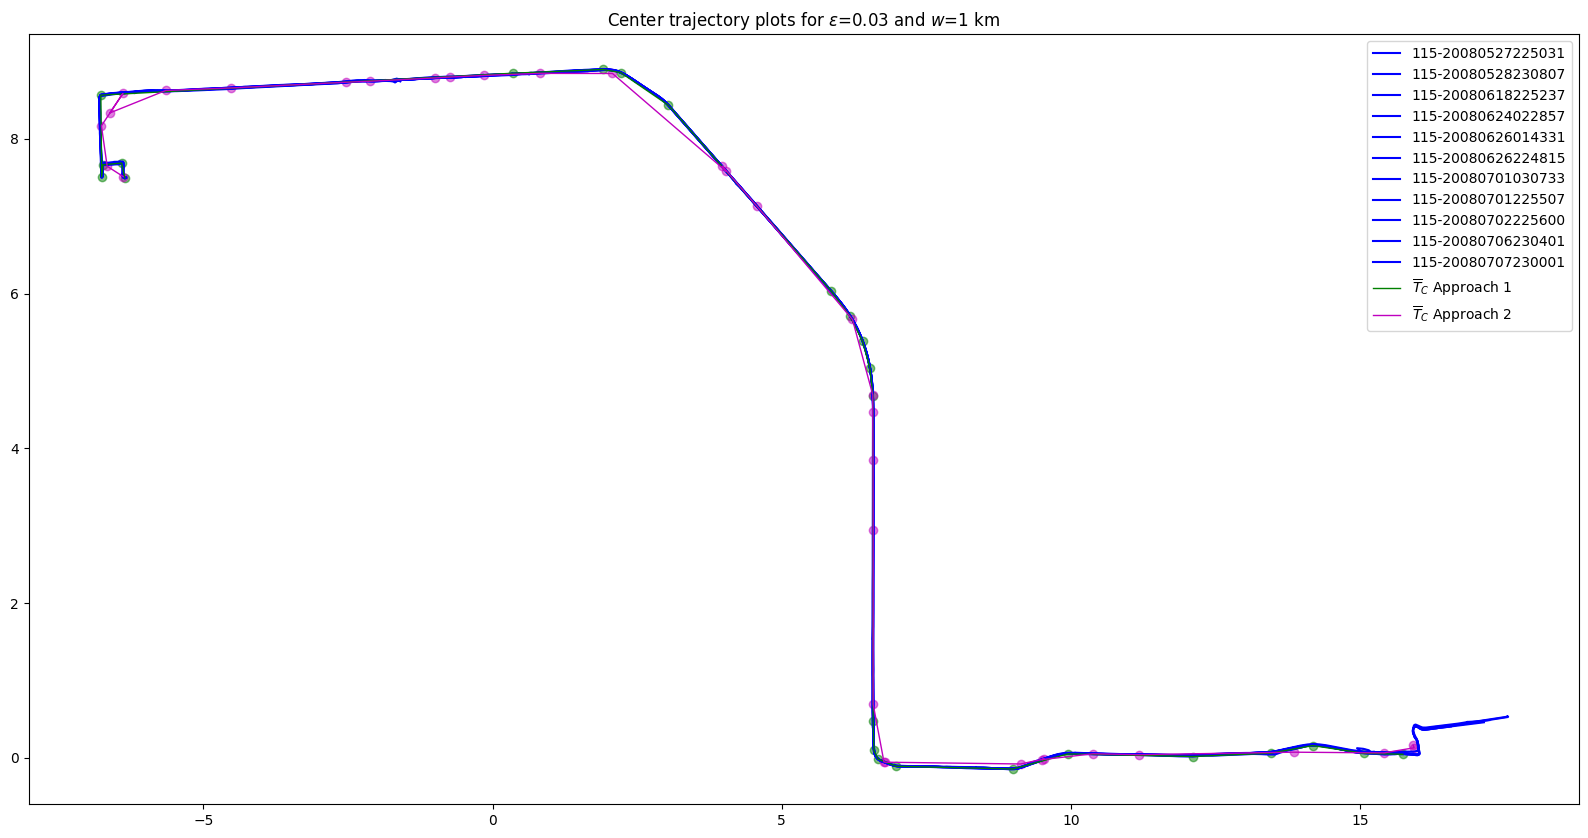

The average distance of trajectories to the center trajectory computed by approach 1 is 1.3481
The average distance of trajectories to the center trajectory computed by approach 2 is 0.1673


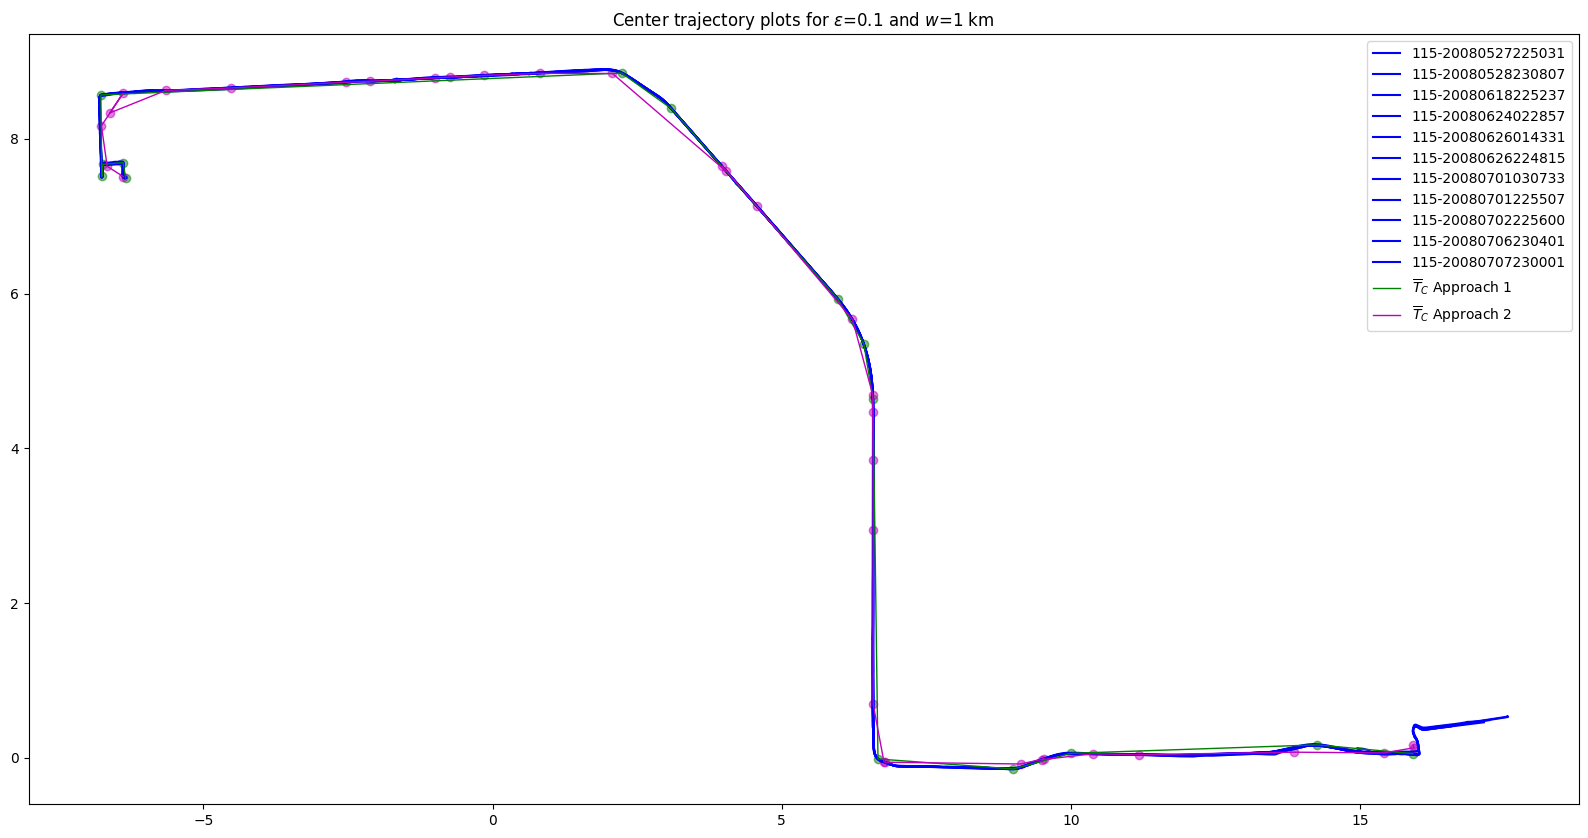

The average distance of trajectories to the center trajectory computed by approach 1 is 2.8010
The average distance of trajectories to the center trajectory computed by approach 2 is 0.1673


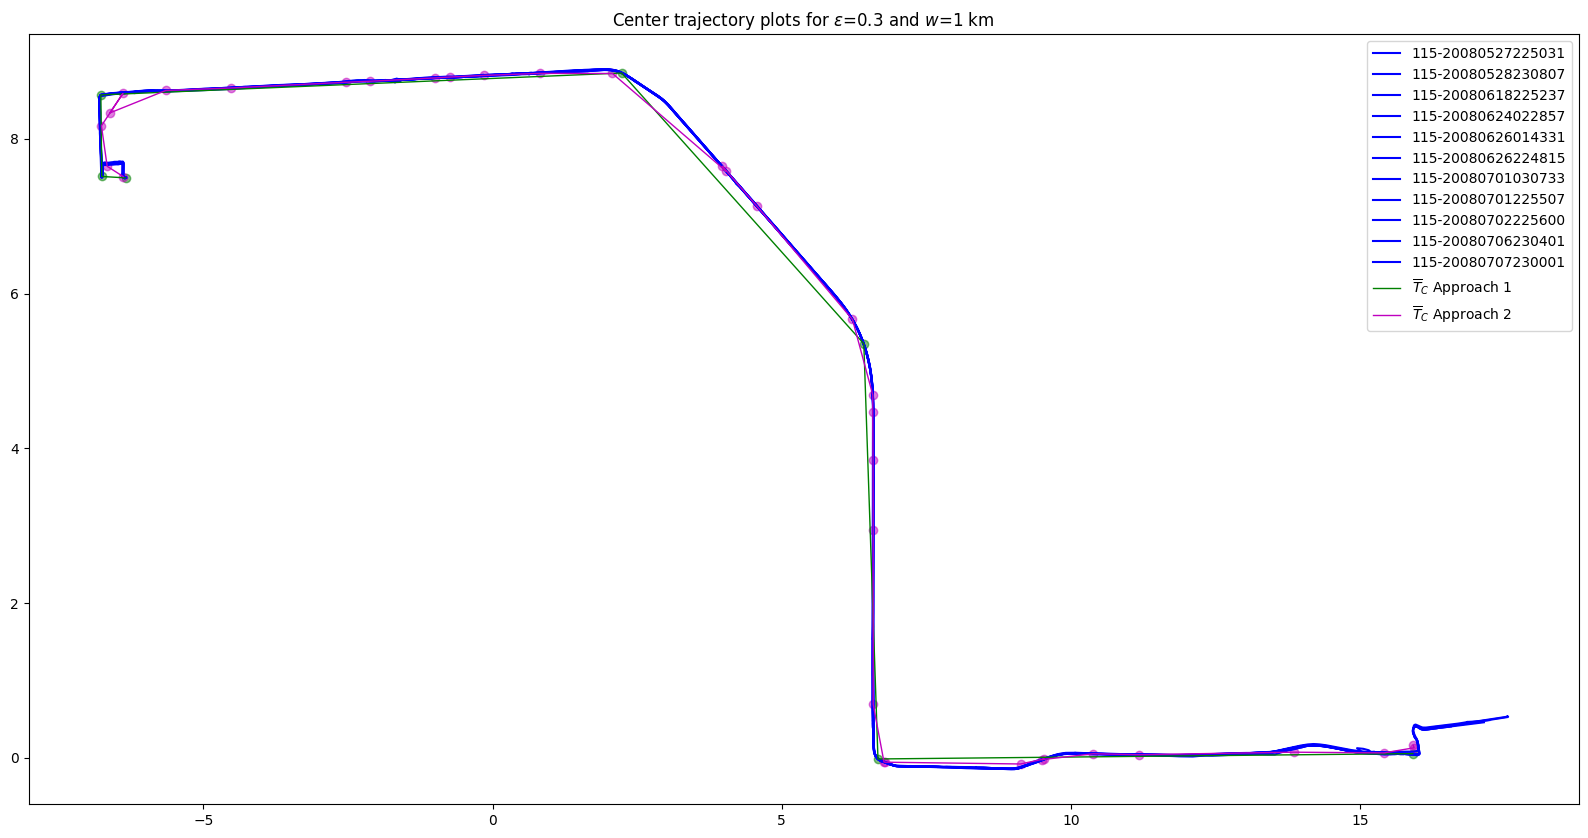

The average distance of trajectories to the center trajectory computed by approach 1 is 4.5345
The average distance of trajectories to the center trajectory computed by approach 2 is 0.1673


In [ ]:
epsilons = [.03, .1, .3]
for e in epsilons:
    windowDistance = 1
    trajectories = [getTrajectory(points, tId) for tId in trajectoryIds]
    simplifiedTrajectories = [TS_greedy(T, e) for T in trajectories]
    centerTrajectory1, centerIndex1, centerTrajectoryId1 = approach1(trajectoryIds, simplifiedTrajectories)
    centerTrajectory2 = approach2(trajectoryIds, trajectories, windowDistance)
    plotResults(trajectories, centerTrajectory1, centerTrajectory2, e)

## Task 5

In [ ]:
import random

trajectoryIds = list(set([p.id for p in points]))
# trajectoryIds = random.sample(trajectoryIds, 100)

In [ ]:
import random 
import sys

def centers_pp(k, trajectories):
    '''
    choose one random trajectory (point) as 'center'
    compute distance from each trajectory to _closest_ 'center'
    select the next 'center' to be the trajectory that is the greatest distance 
    repeat lines 4, 5 until k 'centers' are found
    '''
    centers, dists = [], []
    trajectories = [getTrajectory(points, tId) for tId in trajectoryIds]
    trajectories = [TS_greedy(T, e) for T in trajectories]
    n = len(trajectories)
    # c1 = random.choice(trajectories)
    c1 = random.randint(0, n -1) #selects the first center randomly by generating a random integer between 0 and n-1
    centers.append(c1)
    num = 1
    
    while num < k:  #select the remaining k-1 centers by iteratively selecting the farthes
        dist = []
        for i in range(n):
            d = sys.maxsize
            for j in range(len(centers)):
                td, _ = dtw(trajectories[centers[j]], trajectories[i])
                d = min(d, td)

            dist.append(d)
        
        newC = dist.index(max(dist))
        centers.append(newC)
        dist = []
        num+=1 
    
    return centers

In [ ]:
import random

def randomized_seed(trajectoryIds, k):
    ''' implements randomized seed clustering in Task 5'''
    
    k = min(k, len(trajectoryIds))
    m = len(trajectoryIds)
    clusters = random.sample(list(range(m)), k)
    return clusters

t_max = 20


def kmeans(trajectoryIds, k, seed):
    '''
    partitions a dataset into k clusters by iteratively assigning data points to the nearest cluster center, 
    then recomputing the cluster centers as the mean of the data points in each cluster, 
    until the assignment of points to clusters no longer changes.
    '''
    k = min(k, len(trajectoryIds))
    centers = seed
    
    e = 1.0
    trajectories = [getTrajectory(points, tId) for tId in trajectoryIds]
    trajectories = [TS_greedy(T, e) for T in trajectories]

    new_centers_indices = []
    t = 0
    costs = []

    # terminates when centers equal each other or does more than t_max iterations
    while centers != new_centers_indices and t < t_max:
        if len(new_centers_indices) != 0:
            centers = new_centers_indices
            
        clusters = [[] for i in range(k)]

        # assign all trajectories to the cluster of their closest center
        for trajectory_index in range(len(trajectories)):
            center_distances = [dtw(trajectories[center_trajectory_index], trajectories[trajectory_index])[0]
                                for center_trajectory_index in centers]
            min_center_distance = min(center_distances)
            min_center_index = center_distances.index(min_center_distance)
            closest_center = centers[min_center_index]
            closest_cluster_index = centers.index(closest_center)
            clusters[closest_cluster_index].append(trajectory_index)

        print(f'{centers=}')
        print(f'{clusters=}')

        cost = 0
        for i in range(k):
            traj_i_1 = centers[i]
            cluster = clusters[i]
            for traj_i_2 in cluster:
                c = dtw(trajectories[traj_i_1], trajectories[traj_i_2])[0]
                cost += c
        costs.append(cost)

        # calculate new centers with approach 2
        new_centers = []
        for cluster in clusters:
            cluster_trajectories = [trajectories[i] for i in cluster]
            center_trajectory, center_trajectory_index, center_trajectory_id = approach1(cluster, cluster_trajectories)
            new_centers.append(center_trajectory_id)


        t+=1
        new_centers_indices = new_centers[::]

    # calculate the cost with dtw
    cost = 0
    for i in range(k):
        traj_i_1 = new_centers[i]
        cluster = clusters[i]
        for traj_i_2 in cluster:
            c = dtw(trajectories[traj_i_1], trajectories[traj_i_2])[0]
            cost += c
    costs.append(cost)


    # return center ids
    centers_ids = []
    for center in centers:
        centers_ids.append(trajectoryIds[center])
    return centers_ids, costs[:-1], clusters

In [ ]:
'''
compare the performance of k-means clustering using two different methods for
choosing initial cluster centers: random selection and the K-means++ algorithm
'''
K = [4,6,8,10,12]

e = 1.0
simplifiedTrajectories = [TS_greedy(T, e) for T in trajectories]

# store average costs
average_rand_costs = []
average_kpp_costs = []

redundancy = 3
# run cluster = k redundancy times using both the random and K-means++ methods for selecting initial centers.
for k in tqdm(K, desc='Outer Loop'):
    total_rand_costs = []
    total_kpp_costs = []
    for i in tqdm(range(redundancy), desc="Inner Loop"):
        print(f'{i=} {k=}')
        random_seed = randomized_seed(trajectoryIds, k)
        kpp_seed = centers_pp(k, simplifiedTrajectories)
        rand_cluster, rand_costs, rand_clusters = kmeans(trajectoryIds, k, random_seed)
        kpp_cluster, kpp_costs, kpp_clusters = kmeans(trajectoryIds, k, kpp_seed)

        total_rand_cost = sum(rand_costs)
        total_kpp_cost = sum(kpp_costs)

        total_rand_costs.append(total_rand_cost)
        total_kpp_costs.append(total_kpp_cost)

    average_rand_cost = sum(total_rand_costs) / 3
    total_kpp_cost = sum(total_kpp_costs) / 3
    '''
    The final output of the code is the lists average_rand_costs and average_kpp_costs, which 
    contain the average costs for each experiment run using the random and K-means++ methods, respectively.
    '''
    average_rand_costs.append(average_rand_cost)
    average_kpp_costs.append(total_kpp_cost)

 146, 222, 406, 486, 634, 701, 754, 763, 870, 904, 976, 1070], [4, 6, 7, 10, 24, 26, 42, 43, 46, 50, 52, 64, 69, 73, 81, 82, 84, 94, 113, 133, 135, 136, 177, 184, 219, 232, 234, 262, 269, 271, 276, 277, 280, 291, 299, 300, 309, 327, 332, 335, 339, 342, 382, 394, 408, 431, 436, 461, 469, 473, 476, 478, 483, 489, 495, 496, 503, 510, 511, 513, 521, 524, 525, 526, 539, 555, 556, 563, 565, 566, 599, 600, 616, 618, 632, 636, 657, 667, 689, 692, 695, 707, 714, 717, 718, 723, 734, 739, 745, 778, 782, 794, 802, 811, 812, 825, 830, 832, 837, 843, 844, 860, 878, 881, 889, 908, 914, 916, 930, 936, 939, 973, 981, 989, 991, 992, 1004, 1011, 1035, 1039, 1053, 1074, 1076, 1090, 1097, 1099, 1101, 1107, 1125, 1126, 1161, 1171, 1187], [5, 16, 54, 121, 157, 235, 239, 250, 331, 357, 371, 493, 508, 554, 558, 564, 573, 615, 662, 680, 725, 729, 738, 750, 762, 776, 808, 884, 915, 1023, 1098, 1120, 1145], [1, 27, 33, 68, 76, 125, 165, 179, 208, 231, 238, 246, 251, 323, 349, 350, 370, 375, 392, 416, 487, 494, 50

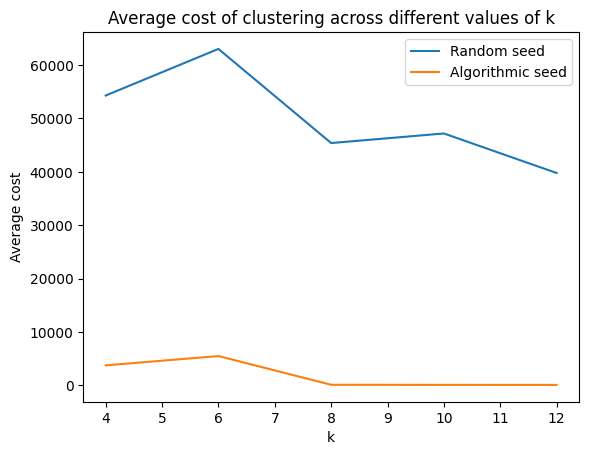

In [ ]:
#Plot of average cost of clustering with different seeding methods for different values of k
plt.plot(K, average_rand_costs, label='Random seed')
plt.plot(K, average_kpp_costs, label='Algorithmic seed')
plt.xlabel("k")
plt.ylabel("Average cost")
plt.title("Average cost of clustering across different values of k")
plt.legend()
plt.show()

In [ ]:
'''
This block populates list rand_cost_matrix and kpp_cost_matrix lists with contain the cost for each cluster 
in each run of the algorithm, and these can be used to compare the performance 
of the two initialization methods.
'''
k = 6
r = 3
rand_cost_matrix = []
kpp_cost_matrix = []
for i in range(r):
    print(f'{i=}')
    random_seed = randomized_seed(trajectoryIds, k)
    kpp_seed = centers_pp(k, simplifiedTrajectories)
    rand_cluster, rand_costs, rand_clusters = kmeans(trajectoryIds, k, random_seed)
    kpp_cluster, kpp_costs, kpp_clusters = kmeans(trajectoryIds, k, kpp_seed)

    rand_cost_matrix.append(rand_costs)
    kpp_cost_matrix.append(kpp_costs)

i=0
centers=[860, 972, 987, 217, 777, 209]
clusters=[[0, 4, 6, 7, 9, 10, 22, 26, 42, 43, 46, 50, 52, 57, 64, 69, 73, 80, 81, 82, 84, 94, 113, 119, 133, 135, 136, 146, 170, 177, 184, 219, 222, 232, 234, 240, 262, 269, 271, 276, 277, 280, 282, 291, 299, 300, 309, 322, 327, 332, 335, 339, 342, 369, 382, 385, 394, 406, 408, 412, 431, 436, 461, 469, 473, 476, 478, 483, 486, 489, 490, 495, 496, 503, 510, 511, 513, 521, 524, 525, 526, 539, 555, 556, 563, 565, 566, 583, 599, 600, 616, 618, 632, 634, 636, 651, 654, 657, 661, 667, 668, 689, 692, 695, 701, 707, 714, 717, 718, 723, 724, 734, 739, 745, 754, 763, 771, 778, 781, 782, 794, 802, 811, 812, 825, 830, 832, 837, 843, 844, 849, 853, 858, 860, 863, 870, 878, 881, 889, 904, 908, 914, 916, 930, 936, 939, 973, 976, 981, 989, 991, 992, 1004, 1019, 1035, 1039, 1042, 1046, 1053, 1070, 1074, 1076, 1090, 1095, 1097, 1099, 1101, 1107, 1115, 1116, 1125, 1126, 1154, 1158, 1161, 1166, 1171, 1179, 1187], [2, 11, 13, 18, 29, 30, 31, 41, 44, 47, 48, 49, 53

In [ ]:
print(f'{rand_cost_matrix=}')
print(f'{kpp_cost_matrix=}')

rand_cost_matrix=[[7070.113599941244, 6151.809977901116, 6151.635702500725, 6151.550349244036, 6151.543397056559], [16192.434712121707, 15201.702831469003, 6152.808684733358, 6152.42603940182, 6152.282080292801, 5830.552421880317, 5827.515198797262, 5827.500585080681], [16049.913158294836, 15206.093262525914, 6152.593081354628, 6151.603908154236, 6151.5617124047385, 6151.533555864121, 6151.530228329603]]
kpp_cost_matrix=[[527.353791802403, 492.5003835423645], [539.2092686692824, 492.5003835423645], [528.484028859327, 492.5003835423645]]


In [ ]:
'''
This code calculates the average cost for each iteration of the k-means clustering algorithm for 
both the random and K-means++ methods, using the cost matrices generated in the previous code block.
It populates the matrix C with this information
'''

m = max([len(c) for c in rand_cost_matrix])
n = max([len(c) for c in kpp_cost_matrix])

rand_iteration_costs = []
# populates the average cost of iteration matrix with the random seeding
for i in range(m):
    iteration_cost = 0
    for c in rand_cost_matrix:
        if i < len(c):
            iteration_cost += c[i]
    average_iteration_cost = iteration_cost / r
    rand_iteration_costs.append(average_iteration_cost)

# populates the average cost of iteration matrix with the kmeans++ seeding
kpp_iteration_costs = []
for i in range(n):
    iteration_cost = 0
    for c in kpp_cost_matrix:
        if i < len(c):
            iteration_cost += c[i]
    average_iteration_cost = iteration_cost / r
    kpp_iteration_costs.append(average_iteration_cost)

print(f'{rand_iteration_costs=}')
print(f'{kpp_iteration_costs=}')

rand_iteration_costs=[13104.153823452594, 12186.535357298679, 6152.345822862903, 6151.8600989333645, 6151.795729918033, 3994.028659248146, 3993.0151423756215, 1942.5001950268936]
kpp_iteration_costs=[531.6823631103374, 492.5003835423645]


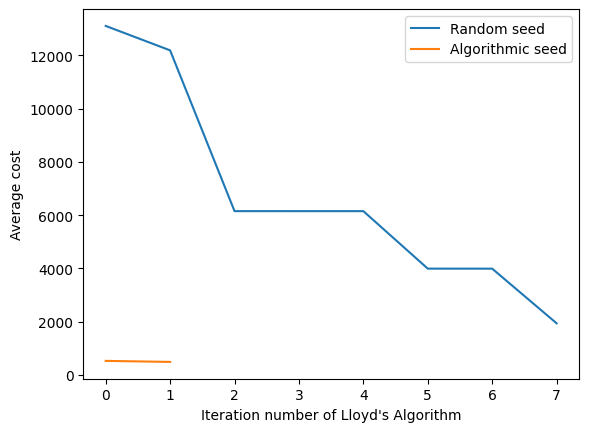

In [ ]:
plt.plot(list(range(m)), rand_iteration_costs, label='Random seed')
plt.plot(list(range(n)), kpp_iteration_costs, label='Algorithmic seed')
plt.xlabel("Iteration number of Lloyd's Algorithm")
plt.ylabel("Average cost")
plt.legend()
plt.show()

centers=[283, 646, 137, 438, 1139, 700]
clusters=[[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 52, 53, 54, 55, 56, 57, 59, 60, 61, 62, 63, 65, 66, 67, 68, 70, 71, 73, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 123, 124, 125, 127, 128, 129, 130, 132, 133, 134, 135, 136, 138, 139, 140, 141, 142, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 168, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 189, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 223, 224, 225, 226, 227, 228, 

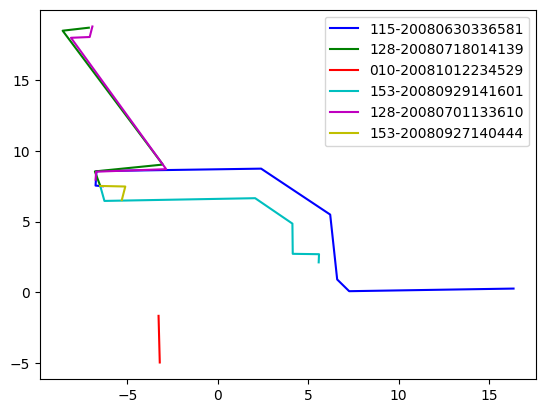

In [ ]:
'''
Plot center trajectories of all clusters evaluated using the proposed seeding with k=6
'''
import matplotlib.colors as mcolors
colors = list(mcolors.BASE_COLORS)

kpp_cluster, kpp_costs, kpp_clusters = kmeans(trajectoryIds, k, kpp_seed)

trajectories = [getTrajectory(points, tId) for tId in trajectoryIds]
trajectories = [TS_greedy(T, e) for T in trajectories]

print(f'{len(trajectoryIds)=}')
print(f'{len(trajectories)=}')

for i, center in enumerate(kpp_cluster):
    traj_i = trajectoryIds.index(center)
    T = trajectories[traj_i]
    plt.plot([p.x for p in T], [p.y for p in T], color=colors[i % len(colors)], label=center)

plt.legend()
plt.show()

# Graveyard

In [ ]:
# # create variables from database
# csvFilePath = '/work/geolife-cars-upd8.csv'
# points, xPoints, yPoints, minX, maxX, minY, maxYY = readPoints(csvFilePath)
# trajectories = [getTrajectory(points, tId) for tId in trajectoryIds]

# print(len(trajectories))

In [0]:
#approach 1
# median interval approach
# center = []
# M = max([len(T) for T in trajectories])
# for i in range(M):
#     P = [T[i] for T in trajectories if len(T) > i]
#     P.sort(key=lambda p: p.x)
#     xBar = P[len(P) // 2].x
#     P.sort(key=lambda p: p.y)
#     yBar = P[len(P) // 2].y
#     # xBar = sum([p.x for p in P]) / len(P)
#     # yBar = sum([p.y for p in P]) / len(P)
#     centerP = Point('', '', xBar, yBar)
#     center.append(centerP)

In [0]:
#approach 2
# windowed interval approach
# windowSize = 10
# center = []
# M = max([len(T) for T in trajectories])
# for i in range(0, M, windowSize):
#     P = []
#     for j in range(windowSize):
#         Pj = [T[i+j] for T in trajectories if len(T) > i+j]
#         P.extend(Pj)
    # P.sort(key=lambda p: p.x)
    # xBar = P[len(P) // 2].x
    # P.sort(key=lambda p: p.y)
    # yBar = P[len(P) // 2].y
#     # xBar = sum([p.x for p in P]) / len(P)
#     # yBar = sum([p.y for p in P]) / len(P)
#     centerP = Point('', '', xBar, yBar)
#     center.append(centerP)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=28f929c6-dc1f-4a03-b897-bf154f2af972' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>